In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
image_path = "../data"
celeba_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
assert isinstance(celeba_dataset, torch.utils.data.Dataset)

In [4]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [21]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    def __init__(self, source_dataset, transform=None):
        super().__init__()
        self.source_dataset = source_dataset
        self.transform = transform
    
    def __getitem__(self, index):
        img, lbl = self.source_dataset[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, lbl[20]

    def __len__(self):
        return len(self.source_dataset)

In [6]:
list(enumerate(celeba_dataset.attr_names))

[(0, '5_o_Clock_Shadow'),
 (1, 'Arched_Eyebrows'),
 (2, 'Attractive'),
 (3, 'Bags_Under_Eyes'),
 (4, 'Bald'),
 (5, 'Bangs'),
 (6, 'Big_Lips'),
 (7, 'Big_Nose'),
 (8, 'Black_Hair'),
 (9, 'Blond_Hair'),
 (10, 'Blurry'),
 (11, 'Brown_Hair'),
 (12, 'Bushy_Eyebrows'),
 (13, 'Chubby'),
 (14, 'Double_Chin'),
 (15, 'Eyeglasses'),
 (16, 'Goatee'),
 (17, 'Gray_Hair'),
 (18, 'Heavy_Makeup'),
 (19, 'High_Cheekbones'),
 (20, 'Male'),
 (21, 'Mouth_Slightly_Open'),
 (22, 'Mustache'),
 (23, 'Narrow_Eyes'),
 (24, 'No_Beard'),
 (25, 'Oval_Face'),
 (26, 'Pale_Skin'),
 (27, 'Pointy_Nose'),
 (28, 'Receding_Hairline'),
 (29, 'Rosy_Cheeks'),
 (30, 'Sideburns'),
 (31, 'Smiling'),
 (32, 'Straight_Hair'),
 (33, 'Wavy_Hair'),
 (34, 'Wearing_Earrings'),
 (35, 'Wearing_Hat'),
 (36, 'Wearing_Lipstick'),
 (37, 'Wearing_Necklace'),
 (38, 'Wearing_Necktie'),
 (39, 'Young'),
 (40, '')]

In [12]:
male_indices = [i for i in range(len(celeba_dataset)) if celeba_dataset.attr[i, 20] == 1 and celeba_dataset.attr[i, 15] == 0]
female_indices = [i for i in range(len(celeba_dataset)) if celeba_dataset.attr[i, 20] == 0 and celeba_dataset.attr[i, 15] == 0]
len(male_indices), len(female_indices)

(59895, 92354)

In [13]:
import random
random.shuffle(male_indices)
random.shuffle(female_indices)

In [16]:
from torch.utils.data import Subset
train_indices = male_indices[:1000] + female_indices[:1000]
random.shuffle(train_indices)
train_set_raw = Subset(celeba_dataset, train_indices)

valid_indices = male_indices[1000:2000] + female_indices[1000:2000]
random.shuffle(valid_indices)
valid_set_raw = Subset(celeba_dataset, valid_indices)

test_indices = male_indices[2000:3000] + female_indices[2000:3000]
random.shuffle(test_indices)
test_set_raw = Subset(celeba_dataset, test_indices)

In [39]:
from torch.utils.data import DataLoader
train_set = ImageDataset(train_set_raw, transform)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)

valid_set = ImageDataset(valid_set_raw, transform)
valid_loader = DataLoader(valid_set, batch_size=16, num_workers=4)

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 128*128
model = Model(input_size).to(device)

lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 15
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
val_loss_hist = [0] * num_epochs
val_accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum().item()
    
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            val_loss_hist[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            val_accuracy_hist[epoch] += is_correct.sum().item()

    loss_hist[epoch] /= len(train_loader.dataset)
    accuracy_hist[epoch] /= len(train_loader.dataset)
    val_loss_hist[epoch] /= len(valid_loader.dataset)
    val_accuracy_hist[epoch] /= len(valid_loader.dataset)
    print(f'Epoch {epoch}, Train loss: {loss_hist[epoch]}, Train accuracy: {accuracy_hist[epoch]}, Valid loss: {val_loss_hist[epoch]}, Valid accuracy: {val_accuracy_hist[epoch]}')

Epoch 0, Train loss: 0.7395003955364228, Train accuracy: 0.6765, Valid loss: 0.49249020624160766, Valid accuracy: 0.7645
Epoch 1, Train loss: 0.4404288911819458, Train accuracy: 0.804, Valid loss: 0.5401516466140747, Valid accuracy: 0.765
Epoch 2, Train loss: 0.35033689230680465, Train accuracy: 0.8435, Valid loss: 0.3990413330793381, Valid accuracy: 0.824
Epoch 3, Train loss: 0.2621383166611195, Train accuracy: 0.89, Valid loss: 0.49750908982753755, Valid accuracy: 0.793
Epoch 4, Train loss: 0.2265221612676978, Train accuracy: 0.906, Valid loss: 0.40418506306409835, Valid accuracy: 0.834
Epoch 5, Train loss: 0.16836530037410558, Train accuracy: 0.9265, Valid loss: 0.4811006077528, Valid accuracy: 0.851
Epoch 6, Train loss: 0.16253224658221008, Train accuracy: 0.9345, Valid loss: 0.4795052928328514, Valid accuracy: 0.8295
Epoch 7, Train loss: 0.18724051675945522, Train accuracy: 0.932, Valid loss: 0.4518978440463543, Valid accuracy: 0.842
Epoch 8, Train loss: 0.14414513643085958, Train

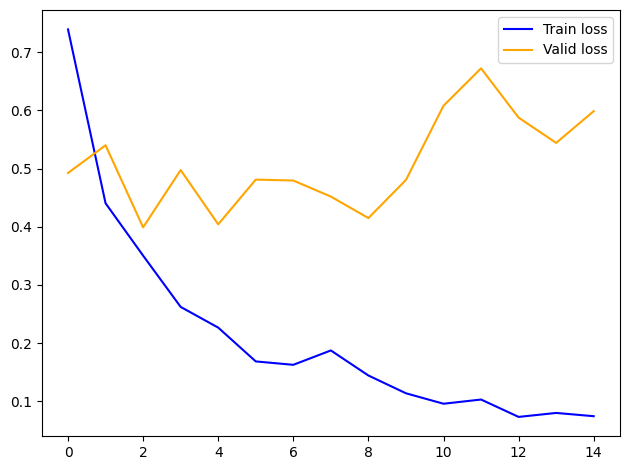

In [57]:
plt.plot(range(num_epochs), loss_hist, c='blue', label='Train loss')
plt.plot(range(num_epochs), val_loss_hist, c='orange', label='Valid loss')
plt.tight_layout()
plt.legend()
plt.show()

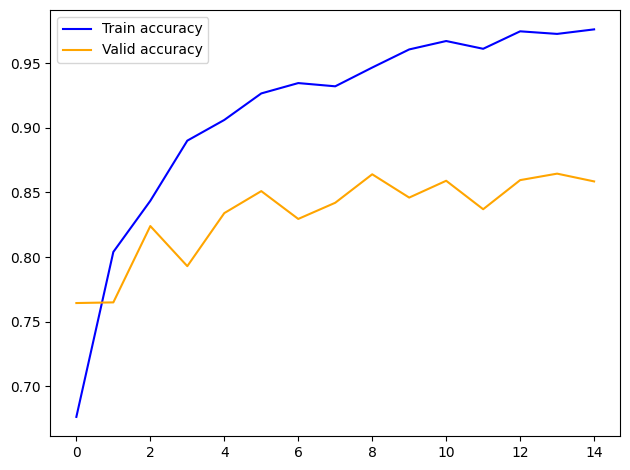

In [58]:
# accuracy_hist = [x.cpu() for x in accuracy_hist]
# val_accuracy_hist = [x.cpu() for x in val_accuracy_hist]
plt.plot(range(num_epochs), accuracy_hist, c='blue', label='Train accuracy')
plt.plot(range(num_epochs), val_accuracy_hist, c='orange', label='Valid accuracy')
plt.tight_layout()
plt.legend()
plt.show()